In [1]:
from google.colab import files
files.upload()  # Upload your kaggle.json here


Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"kaiserchowdhury19","key":"52596862451ebc97775cebbcd6d574ef"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kaiserchowdhury19/potholes-classification-2

Dataset URL: https://www.kaggle.com/datasets/kaiserchowdhury19/potholes-classification-2
License(s): unknown
 97% 1.08G/1.11G [00:11<00:00, 88.3MB/s]
100% 1.11G/1.11G [00:11<00:00, 102MB/s] 


In [4]:
!unzip potholes-classification-2.zip -d your_dataset_folder


Streaming output truncated to the last 5000 lines.
  inflating: your_dataset_folder/train/Pothole/On-The-Job-Pothole-Repair-June-2016_mp4-0175_jpg.rf.28e6eca3ed5268a534d5d2aeef580c5c.jpg  
  inflating: your_dataset_folder/train/Pothole/On-The-Job-Pothole-Repair-June-2016_mp4-0199_jpg.rf.cf9907bb4d3e103f829a059102cf65e7.jpg  
  inflating: your_dataset_folder/train/Pothole/On-The-Job-Pothole-Repair-June-2016_mp4-0200_jpg.rf.30495552e1db6d50ac87ff44153bfda7.jpg  
  inflating: your_dataset_folder/train/Pothole/On-The-Job-Pothole-Repair-June-2016_mp4-0200_jpg.rf.f69d34a2b6c1debed8257c10aed2c58d.jpg  
  inflating: your_dataset_folder/train/Pothole/On-The-Job-Pothole-Repair-June-2016_mp4-0306_jpg.rf.7b843fc046142734022f413e64842955.jpg  
  inflating: your_dataset_folder/train/Pothole/On-The-Job-Pothole-Repair-June-2016_mp4-0345_jpg.rf.bdcae40e9642ad9d164833213cafeaa5.jpg  
  inflating: your_dataset_folder/train/Pothole/On-The-Job-Pothole-Repair-June-2016_mp4-0345_jpg.rf.efb9ee4323d93b1350f8d4

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D,
                                     Dense, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os, numpy as np

In [10]:
train_dir  = '/content/your_dataset_folder/train'
valid_dir  = '/content/your_dataset_folder/valid'
test_dir   = '/content/your_dataset_folder/test'

train_aug = ImageDataGenerator(
    rescale=1/255., rotation_range=20, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest')

val_aug   = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_directory(train_dir,  target_size=(299,299),
                                          batch_size=32, class_mode='binary')
valid_gen = val_aug.flow_from_directory(valid_dir, target_size=(299,299),
                                        batch_size=32, class_mode='binary')
test_gen  = val_aug.flow_from_directory(test_dir,  target_size=(299,299),
                                        batch_size=32, class_mode='binary')

Found 14213 images belonging to 2 classes.
Found 2427 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [11]:
inp = Input(shape=(299,299,3))
base = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp)
base.trainable = False            # freeze for first round

x = base.output                   # feature map 8×8×2048
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)        # 4×4×64
x = GlobalAveragePooling2D()(x)   # 64
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inp, out)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,990,945 (87.70 MB)

 Trainable params: 1,188,161 (4.53 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [12]:
history = model.fit(
    train_gen,
    epochs=20,
    steps_per_epoch=len(train_gen),
    validation_data=valid_gen,
    validation_steps=len(valid_gen))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 411s 876ms/step - accuracy: 0.8019 - loss: 0.5413 - val_accuracy: 0.9085 - val_loss: 0.2170
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 350s 787ms/step - accuracy: 0.8759 - loss: 0.2947 - val_accuracy: 0.8760 - val_loss: 0.2703
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 379s 780ms/step - accuracy: 0.8894 - loss: 0.2687 - val_accuracy: 0.9213 - val_loss: 0.2165
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 340s 765ms/step - accuracy: 0.9030 - loss: 0.2524 - val_accuracy: 0.9279 - val_loss: 0.1725
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 350s 786ms/step - accuracy: 0.9096 - loss: 0.2282 - val_accuracy: 0.8842 - val_loss: 0.2579
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 342s 768ms/step - accuracy: 0.9024 - loss: 0.2341 - val_accuracy: 0.9250 - val_loss: 0.1771
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 344s 772ms/step - accuracy: 0.9105 - loss: 0.2214 - val_accuracy: 0.9390 - val_loss: 0.1596
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 378s 763ms/step - accuracy: 0.9156 -

In [13]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9480 - loss: 0.1501
Test Accuracy: 0.9417


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


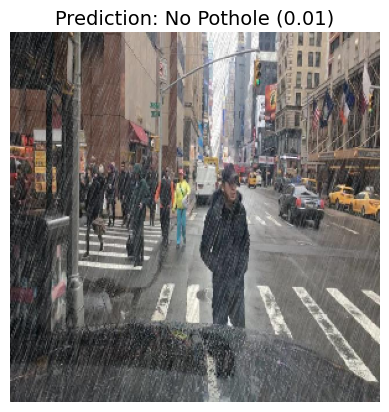

In [15]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# --- LOAD AND PREPROCESS IMAGE ---
img_path = '/content/your_dataset_folder/test/Not Pothole/06ef8fed-e38497d5_jpg.rf.3b81955d7341b1d7f21c6d8c447f0c35.jpg'  # Replace with your actual image path
img = image.load_img(img_path, target_size=(299, 299))  # Resize for InceptionV3
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Shape becomes (1, 299, 299, 3)
img_array /= 255.0  # Normalize if your model was trained with rescaling

# --- PREDICT ---
prediction = model.predict(img_array)[0][0]  # Get probability
label = "Pothole" if prediction >= 0.5 else "No Pothole"

# --- DISPLAY IMAGE AND RESULT ---
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {label} ({prediction:.2f})", fontsize=14)
plt.show()




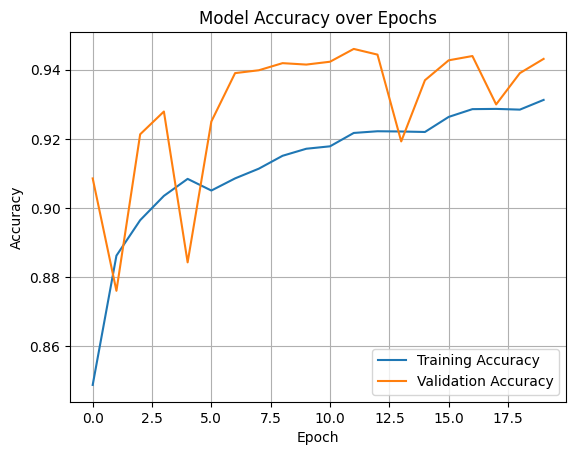

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [22]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyCallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_generator.samples // self.test_generator.batch_size,
            verbose=0
        )
        self.test_accuracies.append(acc)
        print(f"\nTest accuracy after epoch {epoch+1}: {acc:.4f}")

In [24]:
# Initialize the callback
test_callback = TestAccuracyCallback(test_gen)

# Train the model with the callback
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=5,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // valid_gen.batch_size,
    callbacks=[test_callback]
)


Epoch 1/5
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9280 - loss: 0.1738
Test accuracy after epoch 1: 0.9451
444/444 ━━━━━━━━━━━━━━━━━━━━ 350s 789ms/step - accuracy: 0.9280 - loss: 0.1738 - val_accuracy: 0.9483 - val_loss: 0.1349
Epoch 2/5
  1/444 ━━━━━━━━━━━━━━━━━━━━ 50s 115ms/step - accuracy: 0.8750 - loss: 0.2687

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Test accuracy after epoch 2: 0.9468
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8750 - loss: 0.2687 - val_accuracy: 0.9479 - val_loss: 0.1344
Epoch 3/5
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.9339 - loss: 0.1636
Test accuracy after epoch 3: 0.9265
444/444 ━━━━━━━━━━━━━━━━━━━━ 382s 860ms/step - accuracy: 0.9339 - loss: 0.1636 - val_accuracy: 0.9246 - val_loss: 0.1909
Epoch 4/5
  1/444 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - accuracy: 0.9375 - loss: 0.1541
Test accuracy after epoch 4: 0.9265
444/444 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9375 - loss: 0.1541 - val_accuracy: 0.9242 - val_loss: 0.1910
Epoch 5/5
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9336 - loss: 0.1667
Test accuracy after epoch 5: 0.9383
444/444 ━━━━━━━━━━━━━━━━━━━━ 383s 863ms/step - accuracy: 0.9336 - loss: 0.1667 - val_accuracy: 0.9479 - val_loss: 0.1385


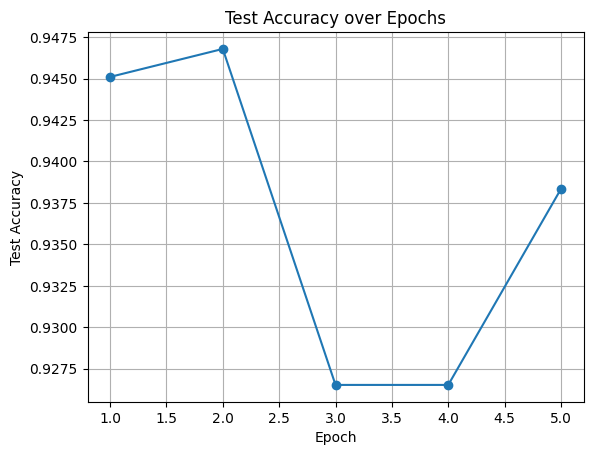

In [26]:
# Plot test accuracy per epoch
plt.plot(range(1, len(test_callback.test_accuracies) + 1), test_callback.test_accuracies, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

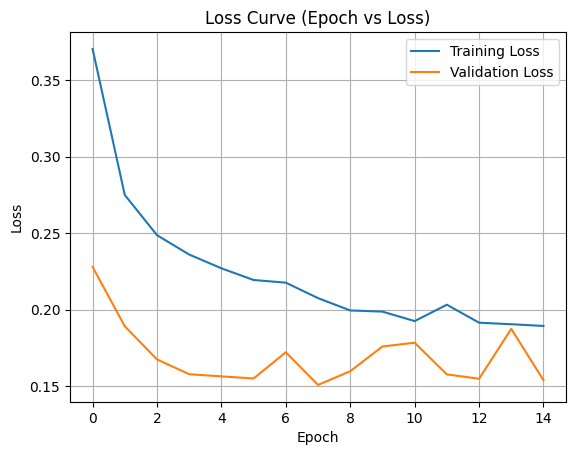

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Curve (Epoch vs Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reset the generator to start from the beginning
train_gen.reset()

# Initialize lists for true labels and predictions
train_labels = []
train_predictions = []

# Iterate through the batches
for i in range(train_gen.samples // train_gen.batch_size):
    images, labels = next(train_gen)  # Get batch
    predictions = model.predict(images, verbose=0)  # Predict batch
    train_labels.extend(labels)
    train_predictions.extend(np.round(predictions))  # Round to 0 or 1

# Convert to numpy arrays
train_labels = np.array(train_labels).astype(int)
train_predictions = np.array(train_predictions).astype(int)

# Generate and print confusion matrix
cm_train = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix for Training Data:")
print(cm_train)


Confusion Matrix for Training Data:
[[6478  415]
 [ 478 6837]]


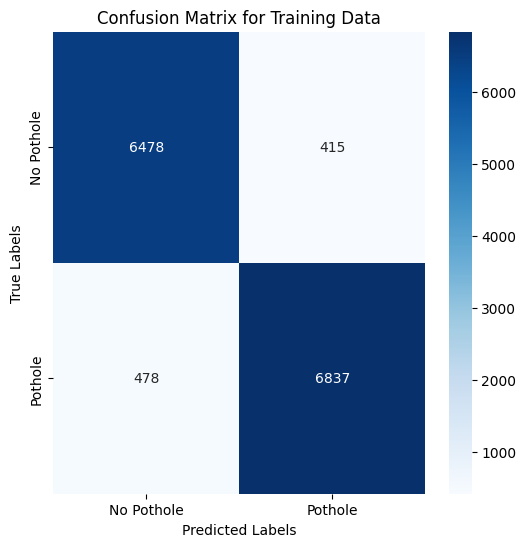

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the training data
cm_train = confusion_matrix(train_labels, train_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pothole', 'Pothole'], yticklabels=['No Pothole', 'Pothole'])
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming train_labels and train_predictions are already defined (from previous steps)

# Calculate Accuracy
accuracy = accuracy_score(train_labels, train_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision = precision_score(train_labels, train_predictions)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(train_labels, train_predictions)
print(f"Recall: {recall:.4f}")

# Calculate F1 Score
f1 = f1_score(train_labels, train_predictions)
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9371
Precision: 0.9428
Recall: 0.9347
F1 Score: 0.9387


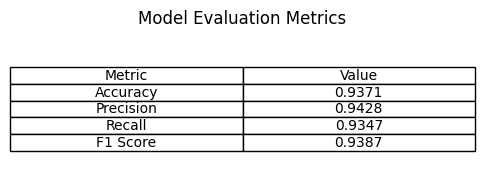

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate the metrics
accuracy = accuracy_score(train_labels, train_predictions)
precision = precision_score(train_labels, train_predictions)
recall = recall_score(train_labels, train_predictions)
f1 = f1_score(train_labels, train_predictions)

# Create the data for the table
metrics = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}']
]

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 2))  # Set size of the figure
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')

# Display the table
plt.title("Model Evaluation Metrics")
plt.show()

In [ ]:
# Save the model
model.save('hybrid model.h5')  # Save as a .h5 file

print("Model saved successfully!")


Model saved successfully!
